# Changes in the 2016.03 Release: Improvements to the molecule drawing code

This is one of a series of posts highlighting changes (mostly new features) in the 2016.03 (Q1 2016) release of the RDKit.

This one focuses on some new capabilities in the chemical reaction handling code.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
print(rdBase.rdkitVersion)
import time
print(time.asctime())

2016.03.1.b1
Fri Apr  8 17:07:05 2016


The RDKit has had the ability to display molecules in the Jupyter (formerly IPython) notebook for quite a while. The original drawing code was purely Python based, but work is underway to replace that code with a C++ molecule renderer (this is the package `rdkit.Chem.Draw.rdMolDraw2D` in Python) so that the same drawings are available in systems other than Python.

This new rendering code is, when available, now the default in Jupyter.

If the RDKit has been built with Cairo support, `rdMolDraw2D` will be used to produce molecule drawings:

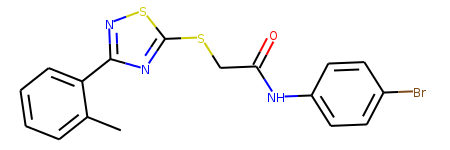

In [2]:
m = Chem.MolFromSmiles('Cc1ccccc1c2nsc(SCC(=O)Nc3ccc(Br)cc3)n2') # molecule from the 2014 TDT challenge
m

But on platforms where this is not the case, the older Python rendering is used to produce images.

On browsers with good SVG support (most, if not all of them these days), you can use tell Jupyter to use SVG to render molecules, this will cause the `rdMolDraw2D` renderer to always be used:

In [3]:
IPythonConsole.ipython_useSVG=True

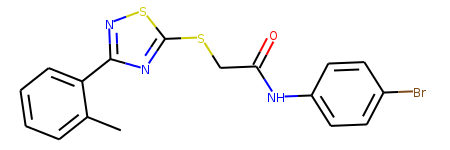

In [4]:
m

The drawings look quite similar to each other, but the SVG version has the advantage that, because SVG is a vector format, it scales nicely if you zoom in or out.

`Draw.MolsToGridImage()` now uses the new renderer too:

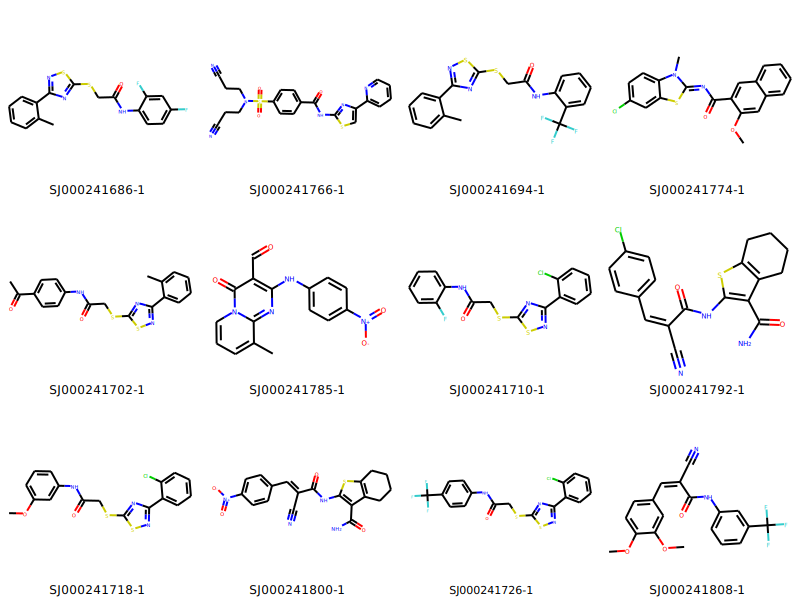

In [5]:
# molecules from the 2014 TDT challenge
d=[('SJ000241686-1', 'Cc1ccccc1c2nsc(SCC(=O)Nc3ccc(F)cc3F)n2'),
 ('SJ000241766-1', 'O=C(Nc1nc(cs1)c2ccccn2)c3ccc(cc3)S(=O)(=O)N(CCC#N)CCC#N'),
 ('SJ000241694-1', 'Cc1ccccc1c2nsc(SCC(=O)Nc3ccccc3C(F)(F)F)n2'),
 ('SJ000241774-1', 'COc1cc2ccccc2cc1C(=O)\\N=C\\3/Sc4cc(Cl)ccc4N3C'),
 ('SJ000241702-1', 'CC(=O)c1ccc(NC(=O)CSc2nc(ns2)c3ccccc3C)cc1'),
 ('SJ000241785-1', 'CC1=CC=CN2C(=O)C(=C(Nc3ccc(cc3)[N+](=O)[O-])N=C12)C=O'),
 ('SJ000241710-1', 'Fc1ccccc1NC(=O)CSc2nc(ns2)c3ccccc3Cl'),
 ('SJ000241792-1', 'NC(=O)c1c2CCCCc2sc1NC(=O)\\C(=C/c3ccc(Cl)cc3)\\C#N'),
 ('SJ000241718-1', 'COc1cccc(NC(=O)CSc2nc(ns2)c3ccccc3Cl)c1'),
 ('SJ000241800-1',
  'NC(=O)c1c2CCCCc2sc1NC(=O)\\C(=C\\c3ccc(cc3)[N+](=O)[O-])\\C#N'),
 ('SJ000241726-1', 'FC(F)(F)c1ccc(NC(=O)CSc2nc(ns2)c3ccccc3Cl)cc1'),
 ('SJ000241808-1', 'COc1ccc(\\C=C(\\C#N)/C(=O)Nc2cccc(c2)C(F)(F)F)cc1OC')]
ms = [Chem.MolFromSmiles(y) for x,y in d]
labels = [x for x,y in d]
Draw.MolsToGridImage(ms,legends=labels,molsPerRow=4)

The new renderer is also better at dealing with highlighting than the old one:

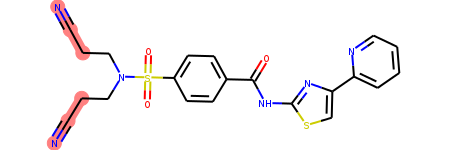

In [6]:
ms[1].GetSubstructMatches(Chem.MolFromSmarts('CC#N'))
ms[1]

The Jupyter notebook integration code does some work behind the scenes in order to get a better depiction that it's worth knowing about if you plan to work with images or SVGs directly.

Here's the default rendering that one gets:

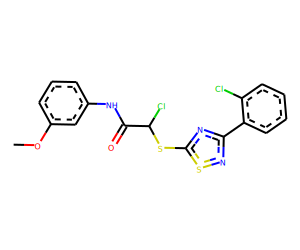

In [7]:
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor

m = Chem.MolFromSmiles('COc1cccc(NC(=O)[C@H](Cl)Sc2nc(ns2)c3ccccc3Cl)c1') # something I made up
rdDepictor.Compute2DCoords(m)
d2d = rdMolDraw2D.MolDraw2DSVG(300,250)
d2d.DrawMolecule(m)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
SVG(svg.replace("svg:",""))

Notice that I had to explicitly generate coordinates for this molecule built from SMILES, that the bonds around the chiral center are not wedged, and that the aromatic rings haven't been kekulized. These can all be handled at once using the new function `rdMolDraw2D.PrepareMolForDrawing()` :

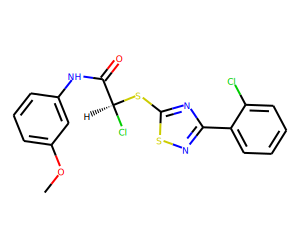

In [8]:
m = Chem.MolFromSmiles('COc1cccc(NC(=O)[C@H](Cl)Sc2nc(ns2)c3ccccc3Cl)c1') # something I made up
tm = rdMolDraw2D.PrepareMolForDrawing(m)
d2d = rdMolDraw2D.MolDraw2DSVG(300,250)
d2d.DrawMolecule(tm)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
SVG(svg.replace("svg:",""))

The Jupyter integration code does this work for you:

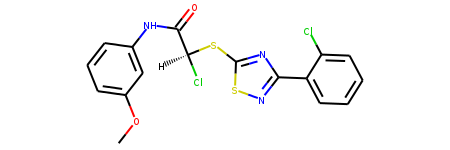

In [9]:
m = Chem.MolFromSmiles('COc1cccc(NC(=O)[C@H](Cl)Sc2nc(ns2)c3ccccc3Cl)c1') # something I made up
m

Notice that this also adds a hydrogen to the chiral center. This results in clearer renderings than the previous behavior, which would just wedge one of the other bonds. The difference is particularly visible with complex fused ring systems:

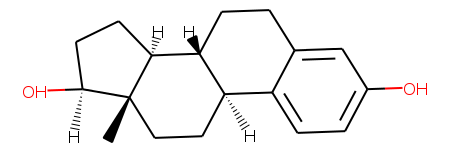

In [10]:
estradiol=Chem.MolFromSmiles('C[C@]12CC[C@@H]3c4ccc(cc4CC[C@H]3[C@@H]1CC[C@@H]2O)O')
estradiol

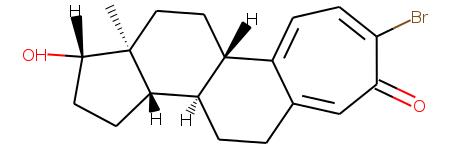

In [11]:
om = Chem.MolFromSmiles('C[C@]12CC[C@@H]3c4ccc(Br)c(=O)cc4CC[C@H]3[C@@H]1CC[C@@H]2O')
om